**<center>Financial Computing</center>**
**<center> Li Wenxuan</center>**

## Import Resources

In [1]:
# NumPy: A Python library used for convert list to arrays
import numpy as np

# pd: Package for data analysis and manipulation tools
import pandas as pd

# plt: Module that import names for the opencv-python library to solve computer vision problems.
import matplotlib.pyplot as plt

# pmdarima: A package for time series analysis based on ARIMA models in the Python environment
import pmdarima as pm

# math: There are operations that can be efficiently solved in mathematics
import math

# os: Modules provide functionality for working with folders
import os 

# seaborn: A statistical charting library based on the unified data structure of matplotlib and Pandas
import seaborn as sns

# statsmodels: A package in python dedicated to statistical analysis
import statsmodels.tsa.api as smt

# ARIMA: Used to build ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

# plot_acf/plot_pacf: Used to plot acf/pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acorr_ljungbox: Used to perform ljungbox test in White Noise Test
from statsmodels.stats.diagnostic import acorr_ljungbox

# stats: Core module for recording test data during performance test runs
from scipy import stats

# ADF: The function used to perform Stationarity Test
from arch.unitroot import ADF

# sklearn.metrics: A package containing functions for evaluating classification/regression models
from sklearn import metrics
from sklearn.metrics import *

# Ignore the warnings we meet
import warnings
warnings.filterwarnings("ignore")

# Set the default plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# Set the absolute work path
path = 'D:/jupyter-notebook/'
os.chdir(path)

## Preparing the data

### Loading the data set

In [2]:
# Data of Apple's stock price
data = pd.read_csv('APPLE.csv')
data["Date"] = pd.to_datetime(data.Date)
data.index = data['Date']
data.drop(columns = ['Date'],inplace = True)
data

,Actual_Price
Date,
2015-12-31,24.199888
2016-01-04,24.220579
2016-01-05,23.613626
2016-01-06,23.151514
2016-01-07,22.174414
...,...
2021-12-23,176.055695
2021-12-27,180.100540
2021-12-28,179.061859


In [3]:
# Data of SP 500 Index Market
data_sp = pd.read_csv('sp500.csv')
data_sp["Date"] = pd.to_datetime(data_sp.Date)
data_sp.index = data_sp['Date']
data_sp.drop(columns = ['Date'],inplace = True)
data_sp

,S&P 500
Date,
2015-12-31,2043.939941
2016-01-04,2012.660034
2016-01-05,2016.709961
2016-01-06,1990.260010
2016-01-07,1943.089966
...,...
2021-12-23,4725.790039
2021-12-27,4791.189941
2021-12-28,4786.350098


### Check the basic information of data set

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-12-31 to 2021-12-30
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Actual_Price  1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [5]:
data.describe()

,Actual_Price
count,1511.000000
mean,65.162859
std,41.670392
min,21.009537
25%,35.896086
50%,46.565548
75%,90.426166
max,180.100540


In [6]:
data_sp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-12-31 to 2021-12-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [7]:
data_sp.describe()

,S&P 500
count,1511.000000
mean,2947.931388
std,716.565165
min,1829.079956
25%,2432.114991
50%,2798.290039
75%,3275.359986
max,4793.060059


### Check whether there exist NAN value

In [8]:
np.sum(data.isna())

Actual_Price    0
dtype: int64

In [9]:
np.sum(data_sp.isna())

S&P 500    0
dtype: int64

### Visualization of Apple's Stock Price

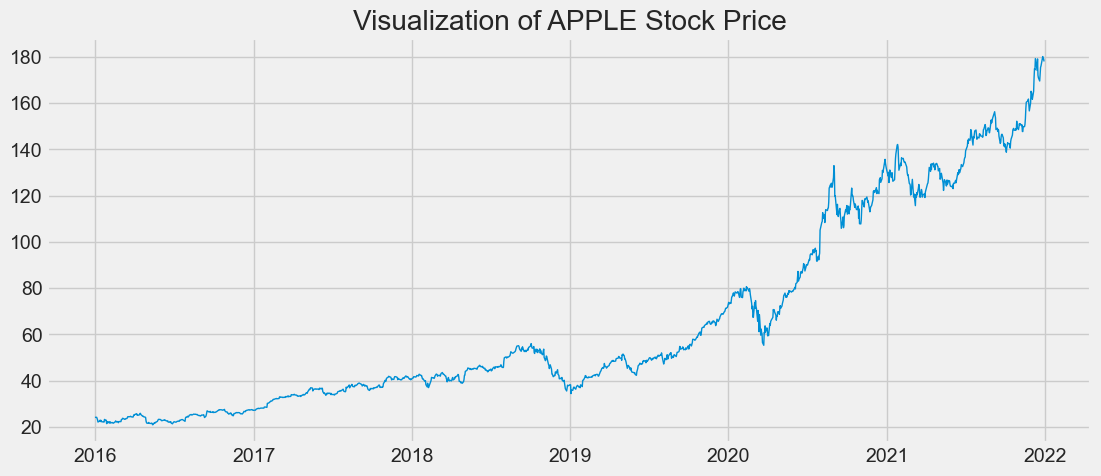

In [10]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data, linewidth = 1)
plt.title('Visualization of APPLE Stock Price')
plt.savefig('Visualization Of APPLE Stock Price.png', dpi=300)
plt.show()

### Visualization of SP 500 Index Market

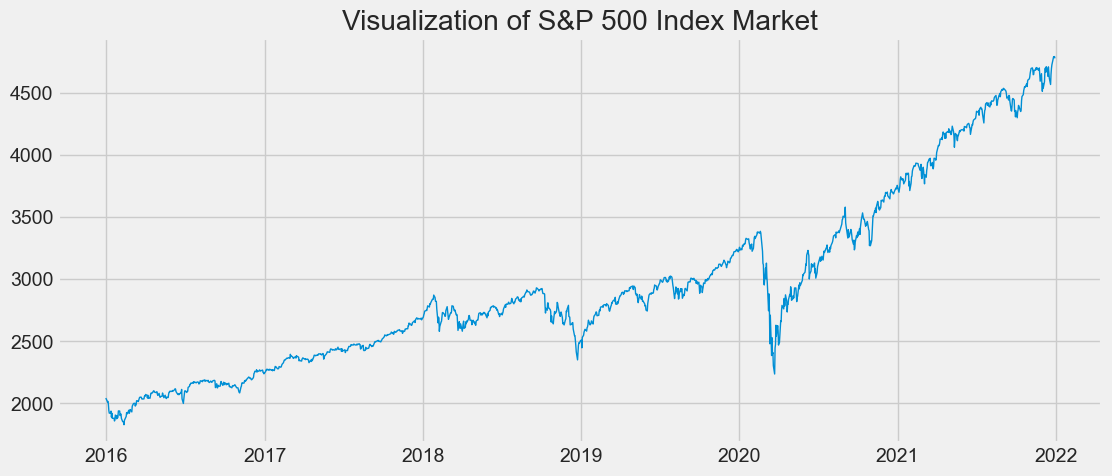

In [11]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_sp, linewidth = 1)
plt.title('Visualization of S&P 500 Index Market')
plt.savefig('Visualization of S&P 500 Index Market.png', dpi=300)
plt.show()

## Basic function for rolling window

In [12]:
def sliding_window(data,sw_width,n_out,sliding_step,in_start):
    '''
    data: The input data frame
    sw_width: The width of window
    n_out: The end position of the new window
    sliding_step: The sliding step of sliding window
    in_start: The start position of sliding
    
    '''
    window_train,window_test, y = [], [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        if in_end <len(data):
            train_seq = data[in_start:in_end]
            test_seq=data[in_end:in_end+1]
            
            window_train.append(train_seq)
            window_test.append(test_seq)
            
            y.append(data[in_end:out_end])
            
        in_start += sliding_step
        
    return window_train, window_test

## Basic function for Time series -- ARIMA model

In [13]:
def Timeseries_ARIMA(train,test,ifPrint , Draw):
    model=pm.auto_arima(train,
                        start_p=1,
                        start_q=1,
                        information_criterion='aic',
                        test='adf',        # use adftest to find optimal 'd'
                        max_p=5, max_q=5,  # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    
    if ifPrint == True:
    # We can print the summary of model for each window
        print(model.summary())
    
    # Forecast
    fc, conf = model.predict(n_periods=len(test), return_conf_int=True)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    
    if Draw == True:
        
        # Set the style of plot
        sns.set_style('whitegrid')
        plt.style.use("fivethirtyeight")
        # Plot
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(train, label='Training', linewidth = 1)
        plt.scatter(test.index,test.values, label='Actual',color = 'black')
        plt.scatter(fc_series.index,fc_series.values, label='Forecast',color = 'r')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.15)
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.savefig('Prediction Result', dpi=300)
        plt.show()
            
    return test.insert(loc=len(test.columns),column='Pred',value=fc)

## The complete process of building an ARIMA model
**Using Window 1 as an example**

### 1. Call the sliding_window function to split the data
**The size of window is 60**

In [14]:
# Calling the sliding_window function to split the data with window size = 60 and step size  = 1
train_width60, test_width60 = sliding_window(data,60,60,1,0)

In [15]:
train_width60[0]

,Actual_Price
Date,
2015-12-31,24.199888
2016-01-04,24.220579
2016-01-05,23.613626
2016-01-06,23.151514
2016-01-07,22.174414
2016-01-08,22.291668
2016-01-11,22.652620
2016-01-12,22.981382
2016-01-13,22.390528


In [16]:
test_width60[0]

,Actual_Price
Date,
2016-03-30,25.325161


### 2. Stationarity Test
**2.1 By using Augmented Dickey-Fuller (ADF) Test to complete the Unit Root Test**    
**2.2 Can be used to initially determine the difference order**

In [17]:
# Use ADF to test the stationarity of original series
print('The stationarity test of the original data: \n')
print(ADF(train_width60[0]).summary().as_text())

# Since the original series(Window 1) does not pass the stationarity test
# We use the 1st order differencing series to re-do the stationarity test
# And, the processed series successfully pass the test
print('\n-------------------------------------------------------------------')
print('\nThe stationarity test of the data after first-order difference:')
print(ADF(train_width60[0].diff().dropna()).summary().as_text())

The stationarity test of the original data: 

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.431
P-value                         0.567
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.55 (1%), -2.91 (5%), -2.59 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-------------------------------------------------------------------

The stationarity test of the data after first-order difference:
   Augmented Dickey-Fuller Results   
Test Statistic                 -6.066
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.55 (1%), -2.91 (5%), -2.59 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### 3. White Noise Test
**By using Box-Pierce Test and Ljung-Box Test**

In [18]:
# Use Box-Pierce Test and Ljung-Box Test to complete the White Noise Test
# The meaning of statistics in the result: 
#    lb_stat: statistic based on the Ljung-Box test
#    lb_pvalue: p-value based on the Ljung-Box test
#    bp_stat: statistic based on the Box-Pierce test
#    bp_pvalue: p-value based on the Box-Pierce test

lags = int(0.5 * len(train_width60[0]) - 2)
white_noise_detection = acorr_ljungbox(train_width60[0].diff().dropna(), 
                                       lags = lags,boxpierce=True,
                                       return_df=True)
white_noise_detection

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.892791,0.344722,0.848883,0.356869
2,1.237820,0.538531,1.171287,0.556747
3,1.854490,0.603150,1.737411,0.628649
4,1.888358,0.756283,1.767948,0.778341
5,2.077583,0.838309,1.935458,0.858002
6,2.189302,0.901491,2.032525,0.916683
7,4.261195,0.749249,3.798729,0.802646
8,4.262226,0.832723,3.799591,0.874737
9,5.720715,0.767512,4.995074,0.834737
10,7.142188,0.711957,6.136913,0.803632


### 4. ACF and PACF Plot of Input Series
**4.1 Draw the series distribution, ACF and PACF of the original series, first-order difference processing, and second-order difference processing, respectively**     
**4.2 Can be used to determine the parameters of ARIMA(p,d,q)**

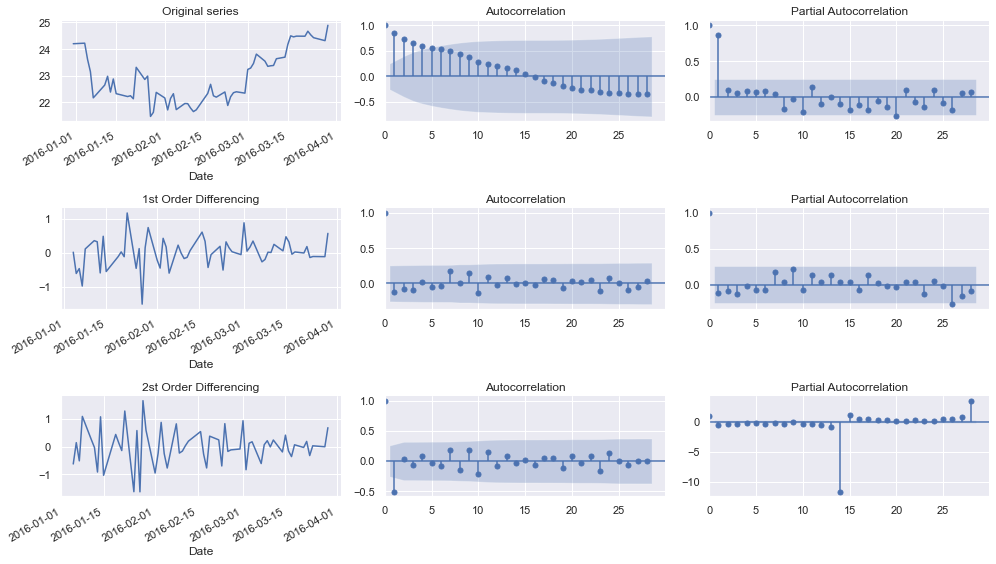

In [19]:
def tsplot(y,lags=None,figsize=(14,8),ifSave=False):
    # Set canvas size and subplot distribution
    sns.set()
    fig = plt.figure(figsize = figsize)
    layout = (3,3)
    
    # The distrubution, acf and pacf of original series in the first row
    ts_original = plt.subplot2grid(layout,(0,0))
    acf_original = plt.subplot2grid(layout,(0,1))
    pacf_original = plt.subplot2grid(layout,(0,2))
    
    # The distrubution, acf and pacf of 1st order difference series in the 2nd row
    ts_1_diff = plt.subplot2grid(layout,(1,0))
    acf_1_diff = plt.subplot2grid(layout,(1,1))
    pacf_1_diff = plt.subplot2grid(layout,(1,2))
    
    # The distrubution, acf and pacf of 2nd order difference series in the 3rd row
    ts_2_diff = plt.subplot2grid(layout,(2,0))
    acf_2_diff = plt.subplot2grid(layout,(2,1))
    pacf_2_diff = plt.subplot2grid(layout,(2,2))
    
    # Draw the distribution of the original series
    y.plot(ax = ts_original, legend=None)
    ts_original.set_title('Original series')
    
    # Draw the acf and pacf of original series
    smt.graphics.plot_acf(y, lags = lags, ax = acf_original)
    smt.graphics.plot_pacf(y, lags = lags, ax = pacf_original)
    
    # Draw the distribution of 1st order difference series
    y.diff().dropna().plot(ax = ts_1_diff, legend=None)
    ts_1_diff.set_title('1st Order Differencing')
    
    # Draw the acf and pacf of 1st order difference series
    smt.graphics.plot_acf(y.diff().dropna(), lags = lags, ax = acf_1_diff)
    smt.graphics.plot_pacf(y.diff().dropna(), lags = lags, ax = pacf_1_diff)
    
    # Draw the distribution of 2nd order difference series
    y.diff().diff().dropna().plot(ax = ts_2_diff, legend=None)
    ts_2_diff.set_title('2st Order Differencing')
    
    # Draw the acf and pacf of 2nd order difference series
    smt.graphics.plot_acf(y.diff().diff().dropna(), lags = lags, ax = acf_2_diff)
    smt.graphics.plot_pacf(y.diff().diff().dropna(), lags = lags, ax = pacf_2_diff)
    
    [ax.set_xlim(0) for ax in [acf_original, pacf_original, 
                                acf_1_diff, pacf_1_diff, 
                                acf_2_diff, pacf_2_diff]]
    sns.despine()
    plt.tight_layout()
    
    if ifSave == True:
        plt.savefig('acf_pacf', dpi=300)
    #return ts_ax,acf_ax,pacf_ax

tsplot(train_width60[0], lags = lags,ifSave=True);

### 5. Build the ARIMA(p,d,q) model

In [20]:
model_test=ARIMA(train_width60[0],order=(0,1,0))
model_fit=model_test.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Actual_Price   No. Observations:                   59
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -34.311
Method:                           css   S.D. of innovations              0.433
Date:                Sat, 21 May 2022   AIC                             72.622
Time:                        16:22:51   BIC                             76.777
Sample:                             1   HQIC                            74.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      0.056      0.208      0.835      -0.099       0.122


### 6. Residual Detection
**6.1 Preliminary observation through visuals**

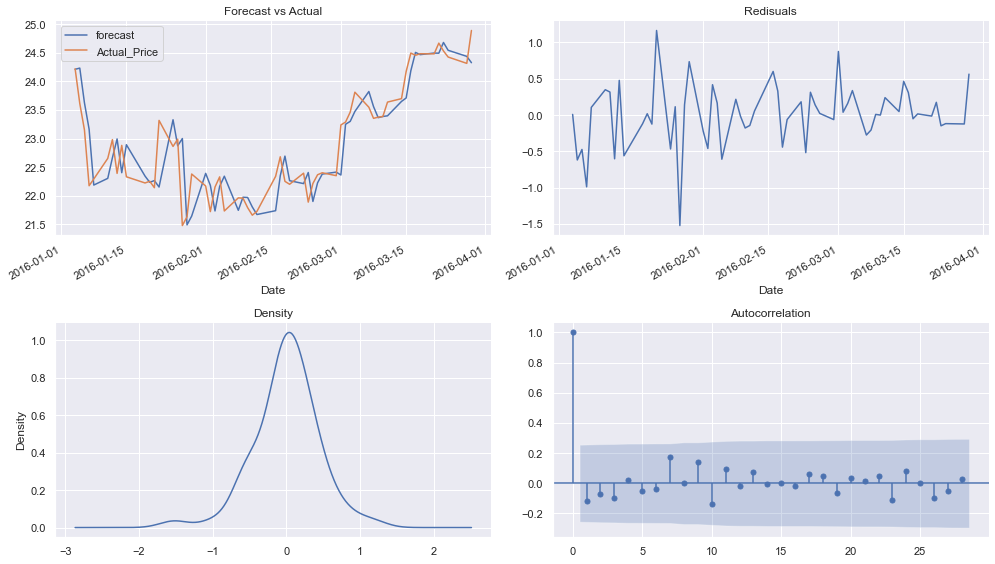

In [21]:
residuals = pd.DataFrame(model_fit.resid)
residuals.columns = ['Residual']
lags = 0.5 * len(train_width60[0]) - 2

fig = plt.figure(figsize = (14,8))
layout = (2,2)
ts_prediction = plt.subplot2grid(layout,(0,0))
ts_residual = plt.subplot2grid(layout,(0,1))
density_residual = plt.subplot2grid(layout,(1,0))
acf_residual = plt.subplot2grid(layout,(1,1))

# Draw the distribution of forecast and actual
model_fit.plot_predict(dynamic=False,ax = ts_prediction)
ts_prediction.set_title('Forecast vs Actual')

# Draw the distribution of residual
residuals.plot(ax=ts_residual, legend=None)
ts_residual.set_title('Redisuals')

# Draw the density distribution of residual
residuals.plot(kind='kde', title='Density', ax=density_residual, legend=None)

# Draw the acf of residual
smt.graphics.plot_acf(residuals,lags=lags,ax=acf_residual)

sns.despine()
plt.tight_layout()
plt.savefig('residual', dpi=300)

**6.2 White noise detection on residuals**

In [22]:
lags = int(0.5 * len(residuals.values) - 2)
white_noise_detection = acorr_ljungbox(residuals, 
                                       lags = lags,boxpierce=True,
                                       return_df=True)
# lb_stat: statistic based on the Ljung-Box test
# lb_pvalue: p-value based on the Ljung-Box test
# bp_stat: statistic based on the Box-Pierce test
# bppvalue: p-value based on the Box-Pierce test
white_noise_detection

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.892791,0.344722,0.848883,0.356869
2,1.237820,0.538531,1.171287,0.556747
3,1.854490,0.603150,1.737411,0.628649
4,1.888358,0.756283,1.767948,0.778341
5,2.077583,0.838309,1.935458,0.858002
6,2.189302,0.901491,2.032525,0.916683
7,4.261195,0.749249,3.798729,0.802646
8,4.262226,0.832723,3.799591,0.874737
9,5.720715,0.767512,4.995074,0.834737
10,7.142188,0.711957,6.136913,0.803632


### 7. Model Evaluation

In [23]:
# Calculate the MSE
mse = sum(residuals.values**2)/len(train_width60[0])

# Calculate the RMSE
rmse = math.sqrt(mse)

# Calculate the MAE
mae = sum(abs(residuals.values))/len(train_width60[0])

print('The MSE of ARIMA with window size 60 is: %.4f' % mse)
print('The RMSE of ARIMA with window size 60 is: %.4f' % rmse)
print('The MAE of ARIMA with window size 60 is: %.4f' % mae)

The MSE of ARIMA with window size 60 is: 0.1842
The RMSE of ARIMA with window size 60 is: 0.4292
The MAE of ARIMA with window size 60 is: 0.3042


### 8. Model Prediction

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.622, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.756, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73.542, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.665, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.177 seconds


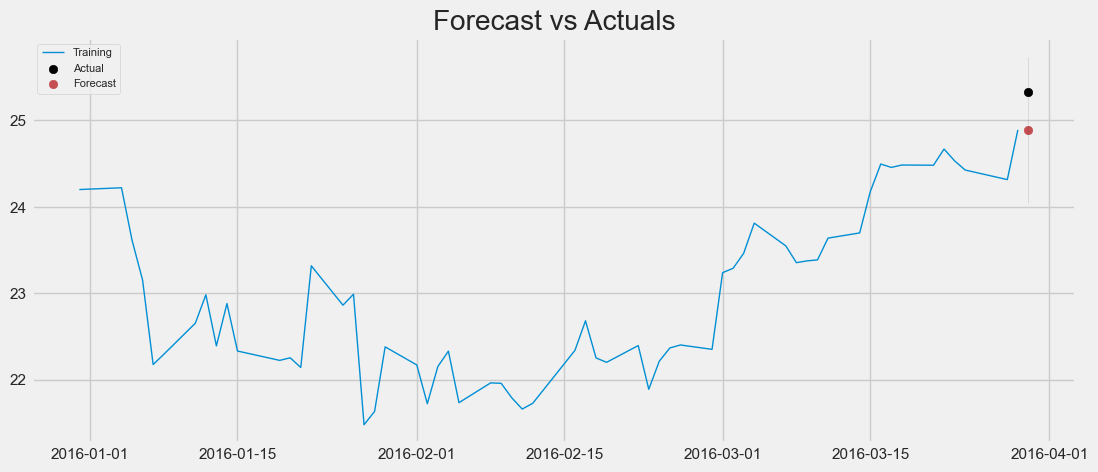

In [24]:
Timeseries_ARIMA(train_width60[0],test_width60[0],False,True)

## Use auto_arima to process every window

### Window size = 60, Step size = 1, Start at 0.

In [25]:
# Calling sliding_wiondiw function to split the data
train_width60, test_width60 = sliding_window(data,60,60,1,0)

In [26]:
# Bulid ARIMA model for each window
for i in range(len(train_width60)):
    Timeseries_ARIMA(train_width60[i],test_width60[i],False,False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.622, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.756, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73.542, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.665, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.179 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75.616, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.979, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.821, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.662, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.127 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71.435, Time=0.06 sec
 ARIMA(0,1,0)(0,

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.215, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60.533, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=62.119, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=62.039, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=63.699, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=62.262, Time=0.02 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=74.238, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=551.281, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=77.543, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=74.624, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52.897, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.925, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.922, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=48.920, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.040, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.897, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.347 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51.549, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.533, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.565, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49.647, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.533, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.135 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52.358, Time=0

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51.228, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.231, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49.575, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.023, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.228, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53.230, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.252, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49.249, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.249, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.587, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=51.251, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0

 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 1.282 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=64.145, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=59.807, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=49.911, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=62.149, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=48.528, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=46.647, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=48.033, Time=0.02 sec
 ARIM

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44.685, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.203, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.155, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.170, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.704, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=43.077, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.355 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.942, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.094, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.983, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.394, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.584, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.921, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44.824, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.237

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=41.259, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=44.827, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.810, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.832, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.395, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.924, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.777, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=41.715, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=43.667, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.245, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.997, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=40.842, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.442, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=42.812

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.569, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37.490, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.153, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.023, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34.061, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.401, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.968, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.330 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.129, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.774, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.190, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.446, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.277, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.103, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40.063

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33.406, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.775, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.161 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.832, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.773, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.487, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37.262, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.565, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.102, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.982, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.805, Time=0.01

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.081, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.068, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.380, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.781, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.603, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.474, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.461, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.612, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.138 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.604, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.452, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.319, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.306, Time=0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.538, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.242, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.580, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.739, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.315, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.929, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=43.220, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=41.582, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.319 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.524, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.731, Time=0.02 se

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44.397, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46.372, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=46.342, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.466, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48.020, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.426 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46.946, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.156, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.101, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.946, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.093, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=46.945, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44.373, Time

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22.523, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22.625, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23.404, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20.335, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23.591, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24.478, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.583, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.497, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.735, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=22.788, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=24.455, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23.404, Time=0.01 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=23.924, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21.5

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.213, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.879, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.663, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.210, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27.470, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=24.239, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=26.237, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.238, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.914, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25.500, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.375 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.517, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.215

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46.434, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.378, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.437, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.533, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.701, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.112 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46.641, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.592, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.650, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.721, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.850, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.106 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46.739, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.560, Time=0

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.377 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=57.507, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=37.804, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=55.572, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=34.786, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=32.091, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=34.082, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=30.400, Time=0.19 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=30.730, Time=0.22 sec
 A

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=55.864, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=26.016, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=31.900, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=22.284, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=20.477, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=22.341, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=33.126, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=23.708, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.165 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=55.247, Time=0.02 sec

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=51.936, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=33.693, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=49.955, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=29.645, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=29.528, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=30.968, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=27.641, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=27.737, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=29.089, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 s

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.102, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.492, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.110, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.130, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.290, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.139 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.255, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.612, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.270, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.290, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.507, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.147 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.128, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.527, Time=0

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=30.656, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=32.653, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=34.427, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0] intercept
Total fit time: 1.559 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19.847, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.877, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.910, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.855, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.158, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.123 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19.835, Time=0.04 sec
 

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26.655, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28.644, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=33.833, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.315 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.686, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.533, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.020, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.707, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.942, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26.678, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=33.844, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.249 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.118, Time=0

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=47.228, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42.916, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=50.872, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=44.069, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=217.667, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=122.152, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=42.776, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=49.163, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=46.484, Time=0.15 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=21.978, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=50.921, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=35.168, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=20.250, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=48.982, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=21.872, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=22.662, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=18.477, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=20.195, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=20.084, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=33.274, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=20.850, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.565 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=21.348, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=54.712

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=65.367, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=56.264, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=50.393, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=43.695, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=45.463, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=45.586, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=48.257, Time=0.09 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=46.916, Time=0.19 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=41.913, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=48.560, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=43.679, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=43.803, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=46.424, Time=0.04 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=45.148, Time=0.11 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]       

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.553, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.517, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.077, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.964, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.617, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.125 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.541, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.529, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.049, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.935, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.754, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.131 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.675, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.623, Time=0

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=99.489, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=92.463, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=97.536, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=88.914, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=76.041, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=75.548, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=74.727, Time=0.07 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=75.628, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=72.727, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=73.560, Time=0.03 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=73.631, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=106.285, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=94.788, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=104.308, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=91.372, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=78.723, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=77.464, Time=0.04 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=77.237, Time=0.07 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=76.566, Time=0.18 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=75.151, Time=0.27 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(5,2,3)(0,0,0)[0] intercept   : AIC=74.607, Time=0.28 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=75.876, Time=0.15 sec
 ARIMA(

 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=81.087, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=79.273, Time=0.22 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=79.492, Time=0.21 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(5,2,1)(0,0,0)[0] intercept
Total fit time: 1.575 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=111.067, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=96.622, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=109.067, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=93.699, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=80.731, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=80.052, Time=0.08 s

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=107.730, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=92.985, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=77.995, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=78.206, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=78.817, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=76.028, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=90.988, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=76.242, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=76.853, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=77.491, Time=0.05 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.090 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=78.042, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=90.818, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=78.827, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=79.258, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.145 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=109.188, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=92.630, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=107.221, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=90.349, Time=0.02 sec


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.949, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.894, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=83.887, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.243, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.124 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=85.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.001, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=83.990, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.342, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.111 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=88.293, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.579, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.544, Time=0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.451, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.188 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.184, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73.004, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.054, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.193 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.128, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.447, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72.206, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.570, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time:

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.374, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.924, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.146 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=77.195, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.862, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.794, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.777, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.202, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.121 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=77.600, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.743, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.732, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.729, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.074, Time=0

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=100.142, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=92.469, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=86.920, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=83.851, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=85.842, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=83.692, Time=0.21 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=84.518, Time=0.23 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=84.334, Time=0.23 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(5,2,1)(0,0,0)[0] intercept
Total fit time: 1.577 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=102.445, Time=0.01 s

 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=75.296, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=76.280, Time=0.02 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=77.294, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=74.366, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=73.271, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=72.720, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=71.230, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=71.052, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=71.056, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=85.507, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=73.051, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.366 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=91.626, Time

 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.950 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=92.903, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=88.333, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=90.911, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=86.237, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=82.036, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=81.934, Time=0.04 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=83.679, Time=0.05 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIM

 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=85.816, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=83.486, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=86.318, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=83.911, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=79.006, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=77.006, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=75.246, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=75.839, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=90.160, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=77.047, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=75.047, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=77.046, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=79.018,

 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=77.846, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=90.346, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.761 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=97.656, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=92.450, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=79.797, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=95.660, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=77.840, Time=0.03 sec
 ARIM

 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=92.640, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=97.375, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=89.599, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=86.054, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=86.732, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=84.063, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=87.611, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=84.744, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=87.920, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.983 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=105.274, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=98.778, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=103.277, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=94.250, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=90.619, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=91.612, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 AR

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.617, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=80.265, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.068, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.209 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.787, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78.631, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78.479, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.839, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.164 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.907, Time=0.02 sec
 

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=85.489, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=75.566, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=98.847, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=74.195, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=144.058, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=75.662, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=74.831, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.030 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=82.630, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=618.701, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 s

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=111.041, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=87.456, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=85.545, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=87.543, Time=0.08 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=84.207, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=82.423, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=84.227, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=98.656, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=86.205, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.865 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=86.697, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=114.113, Time=

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=140.395, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=114.669, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=104.213, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=106.049, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=106.093, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=106.553, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=102.214, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=112.702, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=104.050, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=104.094, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=104.567, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.033 seconds
Performing stepwise searc

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=144.527, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=116.763, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=112.938, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=114.911, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=114.923, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=113.993, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=110.956, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=114.778, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=112.927, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=112.940, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=112.033, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.935 seconds
Performing stepwise searc

 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=117.635, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=138.151, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=116.521, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.457 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=145.866, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=140.164, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=143.866, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=120.681, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=118.026, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=119.958, Time

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=142.750, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=119.929, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=117.350, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=119.342, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=117.206, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=119.024, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=115.225, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=117.941, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=117.049, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=138.154

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=115.539, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=118.476, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=117.277, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=138.344, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=116.288, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.738 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=144.847, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=140.311, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=142.847, Time=0.0

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=160.403, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=140.602, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=131.437, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=133.205, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=132.973, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=132.701, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=129.462, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=138.610, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=131.227, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=130.995, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=130.824, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.203 seconds
Performing stepwise searc

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=137.302, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=140.730, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=135.315, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=142.980, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=155.967, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=136.190, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=138.749, Time=0.09 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.590 seconds
Performing stepwise search to minimize ai

 ARIMA(1,2,0)(0,0,0)[0]             : AIC=157.587, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=135.546, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=136.843, Time=0.07 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.146 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=167.495, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=159.578, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=165.501, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=144.092, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=137.140, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=138.911, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=136.656, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=134.6

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=143.532, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=147.289, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=141.534, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=148.521, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=162.000, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=143.049, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=145.297, Time=0.08 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.554 seconds
Performing stepwise search to minimize ai

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=135.453, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=143.962, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=137.464, Time=0.03 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.304 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=137.597, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=159.749, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=146.047, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=135.651, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=157.778, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=137.610, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=133.652, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=135.600, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=135.612, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : A

 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.329 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=157.023, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=142.237, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=155.045, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=139.846, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=137.413, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=139.263, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=139.008, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 se

 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.381 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=154.861, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=139.327, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=152.861, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=136.001, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=134.244, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=136.090, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 A

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=130.399, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=131.647, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=132.286, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=126.241, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=125.816, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=124.317, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=125.951, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=135.054, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=128.290, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.224 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=131.658, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=128.775, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=132.352, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=129.670, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.989 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=141.909, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=131.571, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=140.008, Time=0.01 se

 ARIMA(0,2,1)(0,0,0)[0]             : AIC=106.604, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=108.518, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=108.599, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=108.565, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=109.278, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.333 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=103.716, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=122.037, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=102.297, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=102.643, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=120.046, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=104.174, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=100.328, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : A

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=103.152, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=126.147, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=102.410, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=99.392, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=100.750, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=99.469, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=101.464, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.446 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=93.655, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=122.951, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=96.762, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=120.951, 

 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=103.842, Time=0.16 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=99.909, Time=0.18 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 2.735 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=79.968, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=119.298, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=88.414, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=82.536, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=117.316, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=81.937, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=81.289, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=80.140, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=85.746, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=83.036, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=78.852, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=81.

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=101.264, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=100.883, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=101.473, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=103.262, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.568 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=99.155, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=97.173, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97.277, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.438, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=124.726, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=117.025, Tim

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101.831, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.794, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.258, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=103.225, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=101.512, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101.294, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.284, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.221, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=103.054, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=104.291, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=101.340, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.211 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=101

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=105.711, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=103.533, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=105.464, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=105.502, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=103.977, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=107.061, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106.521, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=106.839, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.613, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.766, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107.466, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=106.384, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106.067, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]            

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122.757, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122.769, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.617, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.110 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=123.691, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=121.691, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=121.718, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.839, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.128 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=126.234, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=122.585, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=124.234, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144.639, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=146.226, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=147.748, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=142.513, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=144.506, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=144.502, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=142.829, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=146.035, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.294 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.517, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=147.962, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.959, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146.520, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=145.984, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=185.403, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.689, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.621, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.548, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=183.335, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.150 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.937, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.823, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.716, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=184.072, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.122 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=188.635, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=188.465, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=190.221, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=190.007, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.338, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.097 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187.793, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=188.126, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.901, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=189.707, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=190.040, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=187.988, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=188.495, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=187.134, Time=0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=194.993, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=194.249, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=196.711, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=194.309, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=198.863, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.416 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=194.511, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=194.675, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=196.384, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=196.226, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=195.365, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=195.101, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=195.621, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=194.859, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept  

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.376, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.840, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=179.850, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=176.746, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.091 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=181.701, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.104, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.711, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=179.731, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=176.533, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.100 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=177.879, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=175.192, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=173.487, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=166.646, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=231.271, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=164.942, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281.416, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=166.688, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=168.528, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.783 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=160.151, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.622, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=158.937, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=158.8

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.129, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=114.035, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113.971, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=115.495, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.210 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.629, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113.478, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.544, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.190 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.673, Time=0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.167, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=110.942, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=110.804, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=113.939, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.259 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=127.742, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=626.573, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=128.207, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=128.719, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=131.742, Time

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.997, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=112.954, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.316, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.255 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115.947, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.484, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.994, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.006, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.975, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.106 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=117.898, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=114.177, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.929, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=143.736, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=139.822, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.098 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=145.971, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=142.112, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=144.055, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=144.062, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=140.113, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.100 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=146.243, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=142.559, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=144.268, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=144.286, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=140

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.438 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=145.720, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=176.609, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=157.270, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=143.824, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=174.620, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=145.741, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=147.446, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=141.839, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=143.744, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=143.764, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=155.288, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=145.457, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]   

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=148.754, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=181.952, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=162.147, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=147.019, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=179.960, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=148.794, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=145.019, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=146.765, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=146.804, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=160.175, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.468 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=149.523, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1

 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=154.887, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=158.245, Time=0.02 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=156.858, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 1.448 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.651, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144.902, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.863, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146.868, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=142.919, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.122 seconds
Performing stepwise search to minimize 

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=172.821, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=158.807, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=170.822, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=149.874, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=146.889, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=144.749, Time=0.03 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=146.749, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=142.004, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=140.013, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=138.719

 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=147.908, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=149.091, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=149.231, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.216 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=138.661, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.661, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.650, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=136.651, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=132.864, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.083 seconds
Performing stepwise search to minimize 

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=148.318, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.177 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=147.645, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=148.116, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.587, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.212, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.147 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=148.223, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=148.632, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.984, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.512, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.158, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.337, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.925, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=151.485, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.203 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.369, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.497, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.066, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=152.209, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.171 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=173.652, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=175.652, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=169.593, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=213.181, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=169.605, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=171.885, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=171.581, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=239.224, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=203.776, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=170.979, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=171

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.916, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.725, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=148.724, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=148.722, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=148.215, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.114 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=144.804, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141.996, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=143.977, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=143.939, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144.783, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.092 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=144.719, Time=0.04 sec
 A

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=130.639, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=130.581, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=129.800, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.099 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=132.167, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=129.741, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=131.693, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=131.620, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=131.493, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.105 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=131.839, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128.781, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=130

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=128.745, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.874, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=126.760, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134.835, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.109 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=129.299, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=126.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=128.888, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128.881, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135.015, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.156 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=128.875, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=126

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=148.746, Time=0.03 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=152.499, Time=0.10 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=147.637, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=151.043, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=150.668, Time=0.04 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=149.636, Time=0.16 sec

Best model:  ARIMA(3,2,2)(0,0,0)[0]          
Total fit time: 2.629 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.276, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.921, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.802, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146.313, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=152.022, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=166.255, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=168.205, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=173.329, Time=0.02 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.398 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=174.525, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=174.929, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=176.774, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176.454, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=176.558, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=171.179, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=173.837, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=167.447, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=165.786, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=167.505, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept  

 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=195.549, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=197.117, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=196.996, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=211.981, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=198.978, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.488 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=200.096, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=197.198, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=198.326, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=198.119, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=195.647, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.097 seconds
Performing stepwise search to m

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.305, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=270.555, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=270.228, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=270.941, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=266.338, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=268.310, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=268.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=267.146, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=268.982, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.252 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=277.382, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=284.919, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=275.467, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.428, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=290.398, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=284.403, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=281.358, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=287.603, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=287.550, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=285.870, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=285.669, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=284.852, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=280.332, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=283.580, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=283.423, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=285.883, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=286.271, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=281.819, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=284.559, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]  

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=285.231, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=287.070, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=287.125, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=286.445, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.353 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=287.373, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=295.310, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=285.623, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286.503, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=293.727, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=287.287, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=284.761, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=293.838, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=295.789, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=290.102, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=292.102, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=292.102, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=291.689, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=293.945, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=293.824, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=299.930, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=291.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=293.448, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=298.037, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=293.823, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept  

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=293.249, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=287.840, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=289.784, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=289.809, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=290.334, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=291.494, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.238 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=292.234, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=298.993, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=290.256, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=292.562, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=297.079, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=292.217, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=293.973, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]            

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=293.062, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=293.619, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=299.202, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=291.670, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=293.841, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=297.230, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=293.571, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=295.090, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=289.717, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=291.618, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=291.666, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=291.879, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=293.145, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=290.946, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=289.655, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=291.655, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=285.121, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=332.682, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=287.966, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=287.086, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=287.093, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=354.821, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=316.842

 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=269.083, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=276.371, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=269.897, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=270.370, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=269.877, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=283.997, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=272.383, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=268.452, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=270.312, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=272.298, Time=0.08 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 1.493 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=275.036, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=682.766, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : A

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=251.405, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=255.447, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=252.477, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=254.799, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=249.796, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=326.450, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=250.052, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=250.960, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=250.933, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=359.803, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=299.929, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=250.205, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   :

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=214.821, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=210.922, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=214.197, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=216.349, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.249 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=210.959, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=210.810, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=210.287, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=214.573, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=210.941, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=216.179, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.347 seconds
Performing stepwise search to m

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=196.411, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=208.275, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=195.850, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=211.340, Time=0.01 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.717 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=203.241, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=201.267, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=197.689, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=208.258, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=196.697, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=286.161, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=261.063, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=284.166, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=260.393, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=257.371, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=254.974, Time=0.04 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=255.956, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=256.253, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=257.437, Time=0.04 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=257.734, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=253.774, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=255.963, Time=0.02 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=254.684, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=255.009, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]      

 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.931 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=300.576, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=276.928, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=298.584, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=276.700, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=268.667, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=269.170, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=269.542, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=266.668, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=274.700, Time

 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=269.426, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=269.880, Time=0.02 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=271.424, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 1.430 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=302.415, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=283.253, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=300.459, Time=0.01 sec
 A

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.595 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=320.585, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=310.499, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=318.586, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=307.891, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=298.830, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=299.699, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=296.972, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=306.029, Time=0.0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=303.653, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=308.483, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=305.105, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=307.100, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=307.101, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=303.922, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.080 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=308.549, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=305.011, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=306.998, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=307.000, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=303.807, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=311.429, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=313.424, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=313.424, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=310.122, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.112 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=316.230, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=312.499, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=314.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=314.458, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=310.901, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.104 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=316.362, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=312.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=314

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=308.753, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.084 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=316.286, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.904, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=314.402, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=314.544, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=311.912, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.084 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=316.315, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.660, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=314.380, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=314.471, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=311.683, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=314.207, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=372.670, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=316.156, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=318.225, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.735 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=313.371, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=311.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=311.383, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=311.487, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=309.576, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.103 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=310.656, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=308.707, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=309

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=281.771, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=280.788, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.083 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=281.488, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=280.371, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=279.538, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.729, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=278.928, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.079 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=280.826, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=279.720, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=278.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.014, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=278

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=276.003, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.183 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=277.462, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=277.494, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.297, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=275.878, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.202 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=279.813, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=280.021, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.722, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=278.594, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.424, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=274.308, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.165 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=273.474, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=274.930, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=274.889, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=272.248, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.146 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.152, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=277.642, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.619, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=274.495, Ti

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=301.091, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=301.659, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=302.926, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.098 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=291.373, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=287.684, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=289.680, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=289.680, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=285.691, Time=0.0

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.081 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=312.855, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=303.781, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=310.871, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=299.112, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=294.293, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=295.943, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=292.381, Time=0.02 se

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=273.212, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.084 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=316.636, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=298.798, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=314.639, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=291.658, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=279.252, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=281.048, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=277.422, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=289.743, Time

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=309.046, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=285.457, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=267.911, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=269.904, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=269.760, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=265.958, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=283.497, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=267.952, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=267.819, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=268.267, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.986 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(5,2,1)(0,0,0)[0]             : AIC=268.327, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=267.857, Time=0.03 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=269.770, Time=0.04 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 0.880 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=272.739, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=316.505, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=295.524, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=314.507, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=273.916, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=271.741, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=273.405, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=269.9

 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=268.210, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=270.142, Time=0.10 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=267.949, Time=0.17 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=268.411, Time=0.11 sec
 ARIMA(4,2,4)(0,0,0)[0]             : AIC=271.769, Time=0.17 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(3,2,3)(0,0,0)[0]          
Total fit time: 3.154 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=315.921, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=290.873, Time=0.02 se

 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=254.695, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=255.286, Time=0.03 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.205 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=304.164, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=278.434, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=302.196, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=277.963, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=258.035, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=257.417, Time=0.0

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=245.609, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=244.147, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=245.809, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=242.006, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=244.001, Time=0.02 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=243.732, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=242.266, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=263.528, Time=0.01 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=244.379, Time=0.03 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=243.936, Time=0.10 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0]          
Total fit time: 1.385 seconds
Performing stepwise search to

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=237.545, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=252.017, Time=0.01 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=235.940, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=236.364, Time=0.12 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=237.806, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=237.040, Time=0.03 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=238.137, Time=0.07 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 1.308 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=236.473, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=283.401, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=253.768, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=281.404, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2

 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=236.436, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=232.709, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=236.832, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=234.015, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=233.987, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=234.673, Time=0.07 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.700 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=233.050, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=235.719, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.782, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=235.267, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.318, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=235.001, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : A

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.160, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=230.194, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=228.547, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229.743, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=229.784, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.256, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.088 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=230.300, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=228.799, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229.999, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.052, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.567, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.535, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.088 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.298, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=224.873, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225.909, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.711, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=225.902, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.092 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=226.079, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=223.074, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=224.431, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=224.349, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=223.514, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=232.296, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.249, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=234.226, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.744, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.102 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=234.342, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=232.096, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=233.998, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=233.948, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.378, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.104 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=233.490, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=230.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=232

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=250.123, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=246.336, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248.180, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248.149, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=244.347, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.079 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=249.520, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=245.716, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=247.571, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=247.542, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=243.740, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=252.825, Time=0.06 sec
 A

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=239.384, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.774, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.087 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=241.394, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=237.767, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=239.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=239.416, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.792, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.091 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.929, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=243.665, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=243.684, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=240.096

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.675, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=242.722, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.937, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=240.167, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.094 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=244.501, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.636, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=242.709, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.919, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=240.113, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.095 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=252.387, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=249.150, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=250

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=279.078, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=280.896, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=280.881, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=278.704, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.174 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=277.812, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=279.557, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.513, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=278.479, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.178 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(

In [27]:
# Put the actual value and the result of prediction using ARIMA into a frame
Price_width60 = pd.DataFrame(test_width60[0])
for i in range(1,len(test_width60)):
    Price_width60 = Price_width60.append(test_width60[i])

# Rename the columns and save the result into a csv file
Price_width60.columns = ['Actual Price','Predict Price-ARIMA']
Price_width60.to_csv('Arima_result.csv',index=True,encoding='utf_8_sig')

# Show the predict result
Price_width60

,Actual Price,Predict Price-ARIMA
Date,,
2016-03-30,25.325161,24.890591
2016-03-31,25.193399,25.325161
2016-04-01,25.424549,25.193399
2016-04-04,25.685759,25.370200
2016-04-05,25.382948,25.666069
...,...,...
2021-12-23,176.055695,175.975421
2021-12-27,180.100540,176.647927
2021-12-28,179.061859,180.741890


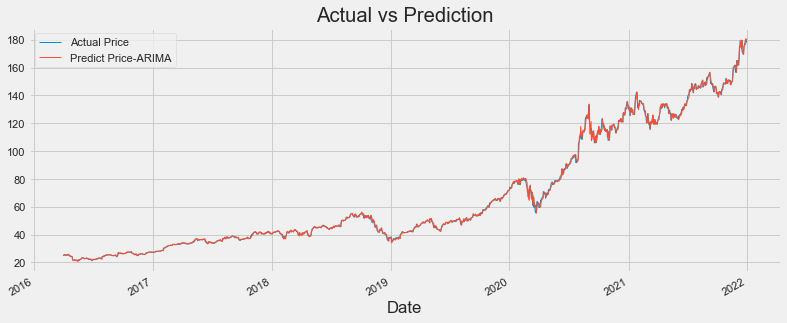

In [28]:
# Show the distruction of Actual price and predict price
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
Price_width60.plot(figsize = (12,5), linewidth = 1)
plt.title('Actual vs Prediction')
plt.savefig('Actual vs Prediction.png', dpi=300)
plt.show()

In [29]:
# Calculate the MSE
mse = mean_squared_error(Price_width60['Actual Price'], Price_width60['Predict Price-ARIMA'])

# Calculate the RMSE
rmse = math.sqrt(mse)

# Calculate the MAE
mae = mean_absolute_error(Price_width60['Actual Price'], Price_width60['Predict Price-ARIMA'])

print('The MSE of ARIMA with window size 60 is: %.4f' % mse)
print('The RMSE of ARIMA with window size 60 is: %.4f' % rmse)
print('The MAE of ARIMA with window size 60 is: %.4f' % mae)

The MSE of ARIMA with window size 60 is: 2.5191
The RMSE of ARIMA with window size 60 is: 1.5872
The MAE of ARIMA with window size 60 is: 0.9407


## Visualization of prediction result of 3 Models

In [30]:
# Data of SP 500 Index Market
data = pd.read_csv('result.csv')
data["Date"] = pd.to_datetime(data.Date)
data.index = data['Date']
data.drop(columns = ['Date'],inplace = True)
data

,Actual Price,Predict Price-ARIMA,Predict Price-ResCNN+LSTM,Predict Price-GRU
Date,,,,
2020-11-05,117.946678,113.903816,113.789230,115.268240
2020-11-06,117.812683,117.946678,113.725330,116.088560
2020-11-09,115.460205,117.812683,113.770256,117.842230
2020-11-10,115.112793,115.460205,113.494354,119.330574
2020-11-11,118.606766,115.112793,113.566310,119.867775
...,...,...,...,...
2021-12-23,176.055695,175.975421,168.815480,169.699570
2021-12-27,180.100540,176.647927,169.152340,169.961360
2021-12-28,179.061859,180.741890,169.689700,170.275710


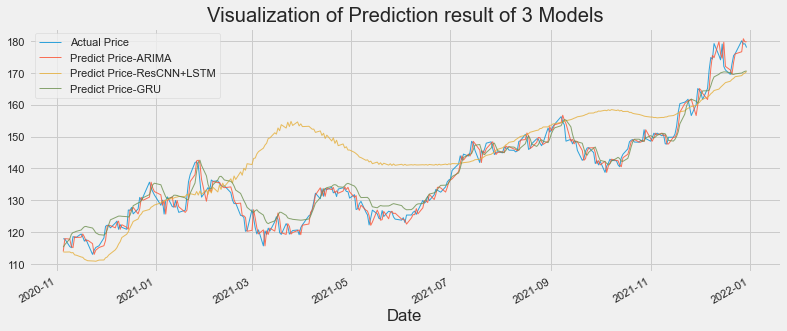

In [31]:
# Show the distruction of Actual price and predict price
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
data.plot(figsize = (12,5), linewidth = 1,alpha = 0.8)
plt.title('Visualization of Prediction result of 3 Models')
plt.savefig('Actual vs Prediction.png', dpi=300)
plt.show()

### Evaluate the ARIMA

In [32]:
# Calculate the MSE
mse = mean_squared_error(data['Actual Price'], data['Predict Price-ARIMA'])

# Calculate the RMSE
rmse = math.sqrt(mse)

# Calculate the MAE
mae = mean_absolute_error(data['Actual Price'], data['Predict Price-ARIMA'])

print('The MSE of ARIMA with window size 60 is: %.4f' % mse)
print('The RMSE of ARIMA with window size 60 is: %.4f' % rmse)
print('The MAE of ARIMA with window size 60 is: %.4f' % mae)

The MSE of ARIMA with window size 60 is: 4.9534
The RMSE of ARIMA with window size 60 is: 2.2256
The MAE of ARIMA with window size 60 is: 1.7121


### Evaluate the GRU

In [33]:
# Calculate the MSE
mse = mean_squared_error(data['Actual Price'], data['Predict Price-GRU'])

# Calculate the RMSE
rmse = math.sqrt(mse)

# Calculate the MAE
mae = mean_absolute_error(data['Actual Price'], data['Predict Price-GRU'])

print('The MSE of GRU with window size 60 is: %.4f' % mse)
print('The RMSE of GRU with window size 60 is: %.4f' % rmse)
print('The MAE of GRU with window size 60 is: %.4f' % mae)

The MSE of GRU with window size 60 is: 12.4826
The RMSE of GRU with window size 60 is: 3.5331
The MAE of GRU with window size 60 is: 2.7383


### Evaluate the ResCNN+LSTM

In [34]:
# Calculate the MSE
mse = mean_squared_error(data['Actual Price'], data['Predict Price-ResCNN+LSTM'])

# Calculate the RMSE
rmse = math.sqrt(mse)

# Calculate the MAE
mae = mean_absolute_error(data['Actual Price'], data['Predict Price-ResCNN+LSTM'])

print('The MSE of GRU with window size 60 is: %.4f' % mse)
print('The RMSE of GRU with window size 60 is: %.4f' % rmse)
print('The MAE of GRU with window size 60 is: %.4f' % mae)

The MSE of GRU with window size 60 is: 164.2697
The RMSE of GRU with window size 60 is: 12.8168
The MAE of GRU with window size 60 is: 9.7627
